## Imports

In [324]:
# main lib
import tensorflow as tf
import tifffile as tiff
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import random
from PIL import Image
import requests
import seaborn as sns
import cv2
# sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# tensorflow
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, Input
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import keras_cv


# from U_net import multi_unet_model
# import segmentation_models as sm
# from transformers import MobileViTFeatureExtractor, MobileViTForSemanticSegmentation

## load data

In [4]:
DATA_PATH = os.path.join(os.getcwd(), '..', '..', 'data')
IMG_DIR_PATH = os.path.join(DATA_PATH, 'images')
LABELS_DIR_PATH = os.path.join(DATA_PATH, 'labels')
IMG_DIR_PATH

'd:\\Cellula Tech CV intern\\Week 3 (Satellite Data & Segmentation)\\end-to-end with pretrained model\\notebook\\..\\..\\data\\images'

In [5]:
img_file_paths = [ os.path.join(IMG_DIR_PATH, i) for i in os.listdir(IMG_DIR_PATH)]
img_file_paths.sort()
img_file_paths

['d:\\Cellula Tech CV intern\\Week 3 (Satellite Data & Segmentation)\\end-to-end with pretrained model\\notebook\\..\\..\\data\\images\\0.tif',
 'd:\\Cellula Tech CV intern\\Week 3 (Satellite Data & Segmentation)\\end-to-end with pretrained model\\notebook\\..\\..\\data\\images\\1.tif',
 'd:\\Cellula Tech CV intern\\Week 3 (Satellite Data & Segmentation)\\end-to-end with pretrained model\\notebook\\..\\..\\data\\images\\10.tif',
 'd:\\Cellula Tech CV intern\\Week 3 (Satellite Data & Segmentation)\\end-to-end with pretrained model\\notebook\\..\\..\\data\\images\\100.tif',
 'd:\\Cellula Tech CV intern\\Week 3 (Satellite Data & Segmentation)\\end-to-end with pretrained model\\notebook\\..\\..\\data\\images\\101.tif',
 'd:\\Cellula Tech CV intern\\Week 3 (Satellite Data & Segmentation)\\end-to-end with pretrained model\\notebook\\..\\..\\data\\images\\102.tif',
 'd:\\Cellula Tech CV intern\\Week 3 (Satellite Data & Segmentation)\\end-to-end with pretrained model\\notebook\\..\\..\\data\\i

In [6]:
len(img_file_paths)

306

In [7]:
images_arr = []

for i in img_file_paths:
    img = tiff.imread(i)
    images_arr.append(img)

images_arr = np.array(images_arr)

## Visualization

In [24]:
max_pixels_intense = [images_arr[:, :, :, i].max() for i in range(images_arr.shape[-1])]
min_pixels_intense = [images_arr[:, :, :, i].min() for i in range(images_arr.shape[-1])]
print(F"max_pixels_intense: {max_pixels_intense} with array length = {len(max_pixels_intense)}")
print(F"min_pixels_intense: {min_pixels_intense} with array length = {len(min_pixels_intense)}")


max_pixels_intense: [6568, 9659, 11368, 12041, 15841, 15252, 14647, 255, 4245, 4287, 100, 111] with array length = 12
min_pixels_intense: [-1393, -1169, -722, -684, -412, -335, -258, 64, -9999, 8, 10, 0] with array length = 12


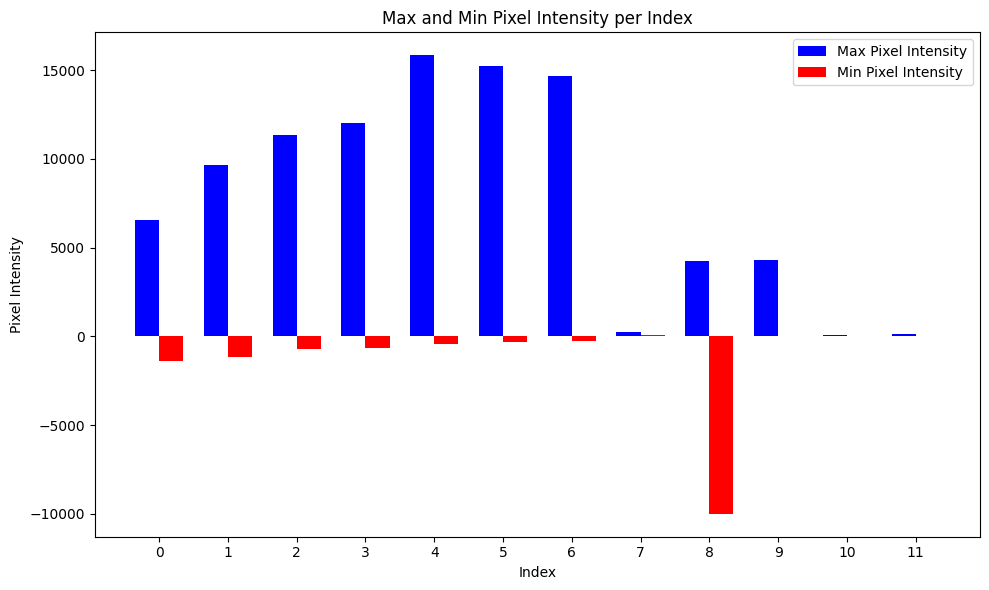

In [35]:

# Number of indices (assuming this is the number of channels or image slices)
indices = np.arange(len(max_pixels_intense))

# Plotting the bar chart
bar_width = 0.35  # Width of the bars
plt.figure(figsize=(10, 6))

# Plot max intensities
plt.bar(x=indices, height=max_pixels_intense, width=bar_width, label='Max Pixel Intensity', color='b')

# Plot min intensities next to max
plt.bar(x=indices + bar_width, height=min_pixels_intense, width=bar_width, label='Min Pixel Intensity', color='r')

# Adding labels and title
plt.xlabel('Index')
plt.ylabel('Pixel Intensity')
plt.title('Max and Min Pixel Intensity per Index')
plt.xticks(indices + bar_width / 2, indices)  # Center x-axis ticks
plt.legend()

# Show plot
plt.tight_layout()
plt.show()

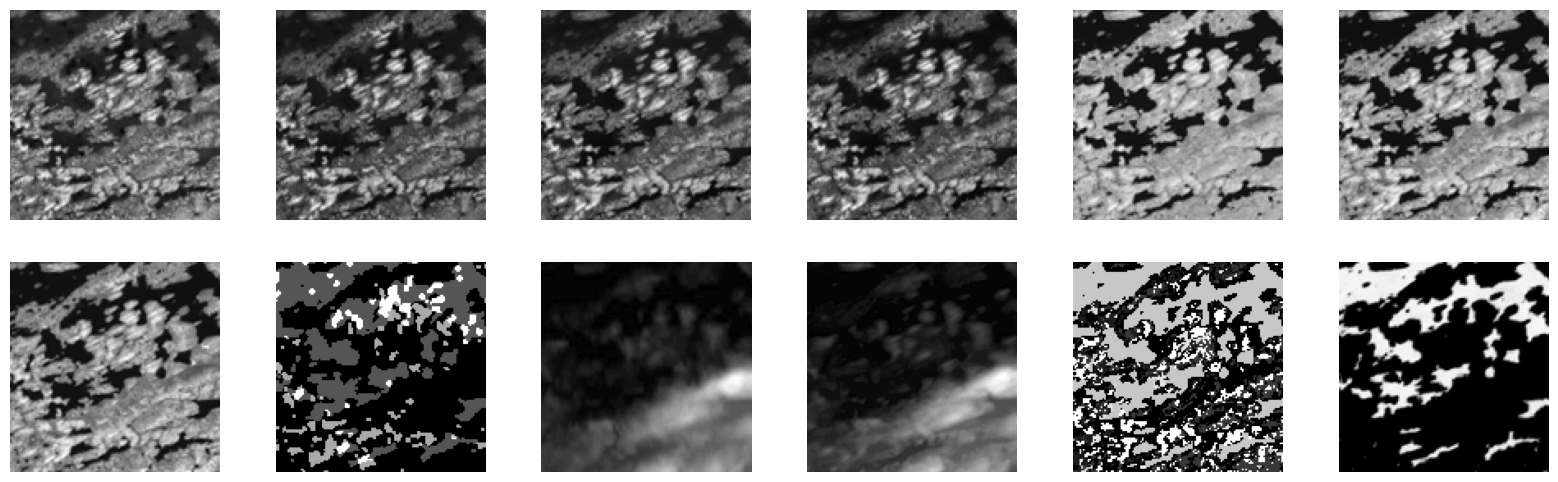

In [86]:
rand_num = random.randint(0, len(images_arr))
plt.figure(figsize=(20, 6))

# plot all channel of a random image 
for i in range(images_arr.shape[-1]):
    plt.subplot(2, 6, i+1)
    plt.imshow(images_arr[rand_num][:, :, i], cmap='gray')
    plt.axis('off')


## Preprocessing

#### Images

In [66]:
def normalize_image(image):
    """
    Normalize image to [0, 1] range.
    """
    normalized_image = np.zeros_like(image, dtype=np.float32)
    
    # normalize each channel separetly
    for channels in range(image.shape[-1]):
        normalized_image[..., channels] = (image[..., channels] - min_pixels_intense[channels]) / (max_pixels_intense[channels] - min_pixels_intense[channels])
    
    return normalized_image

In [81]:
norm_images_arr = np.array([normalize_image(img) for img in images_arr])


In [82]:
norm_images_arr.shape

(306, 128, 128, 12)

In [101]:
# ensuring that the max intense is 1.0
norm_images_arr[...,11].max()

1.0

#### Masks

In [87]:
# removing extra masks
file_names_updated = [i for i in  os.listdir(LABELS_DIR_PATH) if '_' not in i]
file_names_updated.sort()
file_names_updated

['0.png',
 '1.png',
 '10.png',
 '100.png',
 '101.png',
 '102.png',
 '103.png',
 '104.png',
 '105.png',
 '106.png',
 '107.png',
 '108.png',
 '109.png',
 '11.png',
 '110.png',
 '111.png',
 '112.png',
 '113.png',
 '114.png',
 '115.png',
 '116.png',
 '117.png',
 '118.png',
 '119.png',
 '12.png',
 '120.png',
 '121.png',
 '122.png',
 '123.png',
 '124.png',
 '125.png',
 '126.png',
 '127.png',
 '128.png',
 '129.png',
 '13.png',
 '130.png',
 '131.png',
 '132.png',
 '133.png',
 '134.png',
 '135.png',
 '136.png',
 '137.png',
 '138.png',
 '139.png',
 '14.png',
 '140.png',
 '141.png',
 '142.png',
 '143.png',
 '144.png',
 '145.png',
 '146.png',
 '147.png',
 '148.png',
 '149.png',
 '15.png',
 '150.png',
 '151.png',
 '152.png',
 '153.png',
 '154.png',
 '155.png',
 '156.png',
 '157.png',
 '158.png',
 '159.png',
 '16.png',
 '160.png',
 '161.png',
 '162.png',
 '163.png',
 '164.png',
 '165.png',
 '166.png',
 '167.png',
 '168.png',
 '169.png',
 '17.png',
 '170.png',
 '171.png',
 '172.png',
 '173.png',
 '17

In [88]:
labels_arr = []

# append each masks to an array
for i in file_names_updated:
    label_file_path = os.path.join(LABELS_DIR_PATH, i)
    label = plt.imread(label_file_path)
    labels_arr.append(label)

labels_arr = np.array(labels_arr)

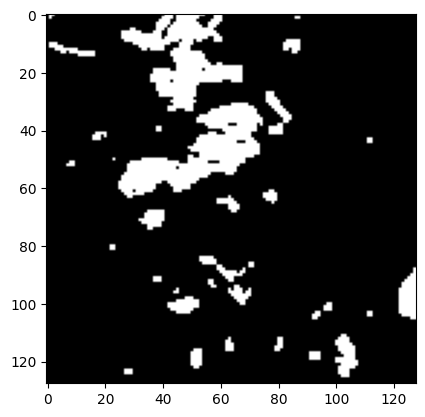

In [92]:
# before [0-1] transformation
plt.imshow(labels_arr[0], cmap='grey')

In [93]:
# transform each mask to [0-1] range
label_binary = labels_arr.copy()
label_binary[label_binary > 0] = 1
label_binary[0]

array([[0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

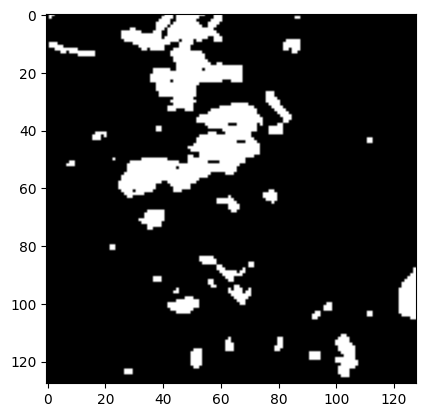

In [94]:
# after [0-1] transformation
plt.imshow(label_binary[0], cmap='grey')

In [203]:
X_train_org, X_test_org, y_train_org, y_test_org = train_test_split(images_arr, label_binary, test_size = 0.10, random_state = 45)


In [102]:
X_train, X_test, y_train, y_test = train_test_split(norm_images_arr, label_binary, test_size = 0.10, random_state = 45)

In [103]:
X_train.shape, y_train.shape

((275, 128, 128, 12), (275, 128, 128))

In [104]:
X_test.shape, y_test.shape

((31, 128, 128, 12), (31, 128, 128))

In [185]:
model = keras_cv.models.DeepLabV3Plus.from_preset(
    "deeplab_v3_plus_resnet50_pascalvoc",
    num_classes=2,
    input_shape=(512, 512, 3),
)

model = Sequential([
    Input((128, 128, 12)),
    Conv2D(filters=3, kernel_size=(3, 3), activation='relu', kernel_initializer='he_normal', padding='same'),
    model,
    Conv2D(1, (1, 1), activation='sigmoid')
])

In [186]:
model.summary()

Model: "sequential_72"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_67 (Conv2D)              │ (None, 128, 128, 3)    │           327 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ deep_lab_v3_plus_9              │ (None, 128, 128, 21)   │    39,191,488 │
│ (DeepLabV3Plus)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_68 (Conv2D)              │ (None, 128, 128, 1)    │            22 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 39,191,837 (149.50 MB)

 Trainable params: 39,146,813 (149.33 MB)

 Non-trainable params: 45,024 (175.88 KB)

In [187]:
iou_metric = MeanIoU(2)
model.compile(optimizer='adam', loss=BinaryCrossentropy(), metrics=[iou_metric, 'accuracy'])

In [197]:
import numpy as np

# Example: Compute class weights based on pixel frequencies
class_weights = np.array([1.0, 10.0])  # You can calculate weights based on your class distribution

# Define a function to calculate pixel-wise weights
def get_sample_weights(y, class_weights):
    sample_weights = np.zeros(y.shape[:3])  # Same shape as y_train but without the last channel
    for i, w in enumerate(class_weights):
        sample_weights[y == i] = w
    return sample_weights

# Apply this to your labels
sample_weights = get_sample_weights(y_train, class_weights)


In [199]:
sample_weights.shape

(275, 128, 128)

In [202]:
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.15)

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 80s 10s/step - accuracy: 0.8221 - loss: 0.5899 - mean_io_u_4: 0.3694 - val_accuracy: 0.3138 - val_loss: 0.7979 - val_mean_io_u_4: 0.3431
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 77s 10s/step - accuracy: 0.8473 - loss: 0.5727 - mean_io_u_4: 0.3696 - val_accuracy: 0.3138 - val_loss: 0.7961 - val_mean_io_u_4: 0.3431
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 73s 9s/step - accuracy: 0.8771 - loss: 0.5573 - mean_io_u_4: 0.3873 - val_accuracy: 0.3138 - val_loss: 0.7947 - val_mean_io_u_4: 0.3431
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 75s 9s/step - accuracy: 0.8776 - loss: 0.5527 - mean_io_u_4: 0.3799 - val_accuracy: 0.3137 - val_loss: 0.7929 - val_mean_io_u_4: 0.3431
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 69s 9s/step - accuracy: 0.8878 - loss: 0.5448 - mean_io_u_4: 0.3654 - val_accuracy: 0.3670 - val_loss: 0.7578 - val_mean_io_u_4: 0.3431
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 70s 9s/step - accuracy: 0.8862 - loss: 0.5411 - mean_io_u_4: 0.3788 - val_accuracy: 0.3391 - val_loss:

KeyboardInterrupt: 

In [322]:
# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss',  # Monitor validation loss
                               patience=5,          # Number of epochs with no improvement after which training will be stopped
                               restore_best_weights=True)  # Restore the model with the best weights during training

# Define the ModelCheckpoint callback
checkpoint = ModelCheckpoint(filepath='pre_trained_deeplabv3_plus_with_ES_MC.keras',  # Path to save the model
                             monitor='val_loss',        # Metric to monitor (can also be 'val_accuracy')
                             save_best_only=True,       # Save only the model with the best performance
                             save_weights_only=False,   # Save full model (False) or only weights (True)
                             mode='min',                # Mode to monitor: 'min' for loss, 'max' for accuracy
                             verbose=1)                 # Verbosity level


In [204]:
model.fit(X_train_org, y_train, epochs=50, batch_size=32, validation_split=0.15)

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 87s 9s/step - accuracy: 0.8240 - loss: 0.5167 - mean_io_u_4: 0.3661 - val_accuracy: 0.7855 - val_loss: 0.5455 - val_mean_io_u_4: 0.3431
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 75s 9s/step - accuracy: 0.8824 - loss: 0.4772 - mean_io_u_4: 0.3737 - val_accuracy: 0.8298 - val_loss: 0.5211 - val_mean_io_u_4: 0.3431
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 74s 9s/step - accuracy: 0.9047 - loss: 0.4610 - mean_io_u_4: 0.3725 - val_accuracy: 0.8552 - val_loss: 0.5035 - val_mean_io_u_4: 0.3431
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 71s 9s/step - accuracy: 0.9100 - loss: 0.4549 - mean_io_u_4: 0.3723 - val_accuracy: 0.8369 - val_loss: 0.5140 - val_mean_io_u_4: 0.3431
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 70s 9s/step - accuracy: 0.9161 - loss: 0.4464 - mean_io_u_4: 0.3771 - val_accuracy: 0.8689 - val_loss: 0.4921 - val_mean_io_u_4: 0.3431
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 70s 9s/step - accuracy: 0.9201 - loss: 0.4428 - mean_io_u_4: 0.3705 - val_accuracy: 0.8683 - val_loss: 0

In [344]:
label_pred_1 = model.predict(X_test_org)
label_pred_1[label_pred_1 >= 0.5] = 1
label_pred_1[label_pred_1 < 0.5] = 0
len(label_pred_1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


31

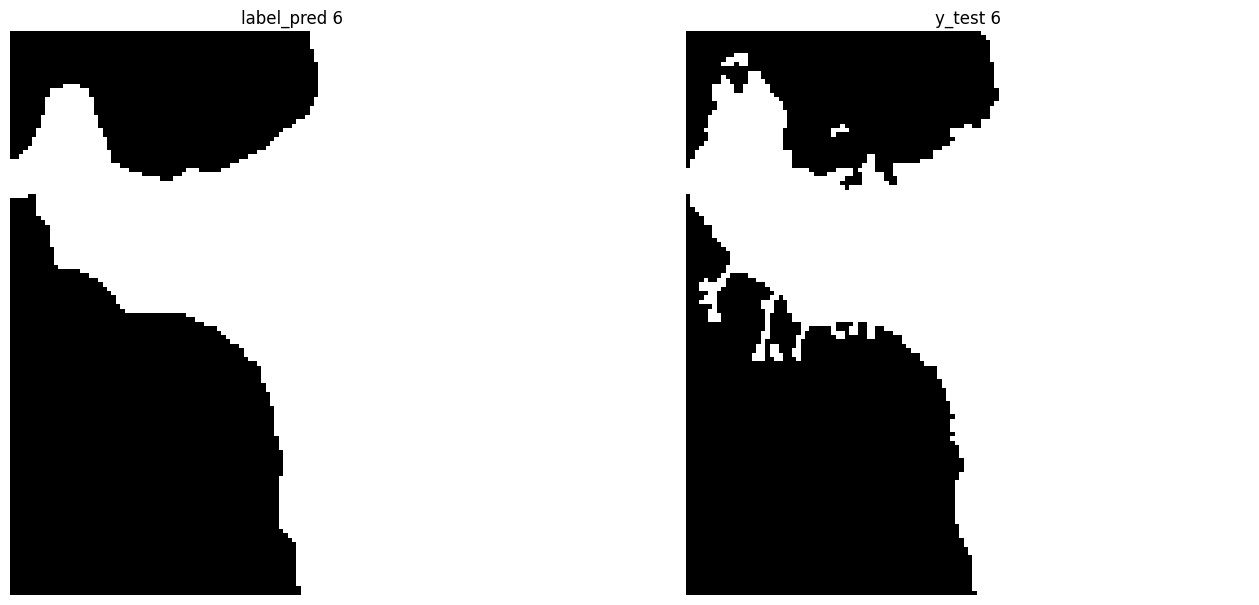

In [372]:
rand_num = random.randint(0, len(label_pred_1)-1)
plt.figure(figsize=(16, 14))
plt.subplot(121)
plt.axis('off')
plt.title(f'label_pred {rand_num}')
plt.imshow(label_pred_1[30], cmap='gray')
plt.subplot(122)
plt.axis('off')
plt.title(f'y_test {rand_num}')
plt.imshow(y_test_org[30], cmap='gray')

In [349]:
model.evaluate(X_test_org, y_test_org)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9351 - loss: 0.3280 - mean_io_u_4: 0.3765


[0.3279578685760498, 0.3764658272266388, 0.935143232345581]

In [323]:
model.fit(X_train_org, y_train, epochs=10, batch_size=32, validation_split=0.15, callbacks=[early_stopping, checkpoint])


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.9527 - loss: 0.3229 - mean_io_u_4: 0.3662 
Epoch 1: val_loss improved from inf to 0.36645, saving model to pre_trained_deeplabv3_plus_with_ES_MC.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 79s 10s/step - accuracy: 0.9528 - loss: 0.3224 - mean_io_u_4: 0.3671 - val_accuracy: 0.9229 - val_loss: 0.3665 - val_mean_io_u_4: 0.3431
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.9539 - loss: 0.3206 - mean_io_u_4: 0.3644  
Epoch 2: val_loss did not improve from 0.36645
8/8 ━━━━━━━━━━━━━━━━━━━━ 76s 9s/step - accuracy: 0.9539 - loss: 0.3201 - mean_io_u_4: 0.3655 - val_accuracy: 0.9162 - val_loss: 0.3741 - val_mean_io_u_4: 0.3431
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.9591 - loss: 0.3098 - mean_io_u_4: 0.3749  
Epoch 3: val_loss improved from 0.36645 to 0.36499, saving model to pre_trained_deeplabv3_plus_with_ES_MC.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 79s 10s/step - accuracy: 0.9586 - loss: 0.3103 - mean_io_u_4: 0.3748 - 

In [301]:
model.save('pre_trained_deeplabv3_plus.h5')

In [9]:
from tensorflow.keras.models import Sequential, load_model
import tifffile as tff
import numpy as np
import matplotlib.pyplot as plt
model_2 = load_model('pre_trained_deeplabv3_plus_with_ES_MC.keras')

c:\Users\lenovo\anaconda3\envs\DEPI\lib\site-packages\keras\src\saving\saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 201 variables whereas the saved optimizer has 400 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [12]:
img_test = tff.imread('D:\\Cellula Tech CV intern\\Week 3 (Satellite Data & Segmentation)\\end-to-end with pretrained model\\flask\\uploads\\0.tif')
img_test = np.expand_dims(img_test, axis=0)
img_test.shape

(1, 128, 128, 12)

In [16]:
predicted_mask = model_2.predict(img_test)[0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


In [25]:
predicted_mask[:,:, 0].shape

(128, 128)

In [27]:
from PIL import Image
mask_img = Image.fromarray(predicted_mask[:,:, 0])
(mask_img)

<PIL.Image.Image image mode=F size=128x128>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


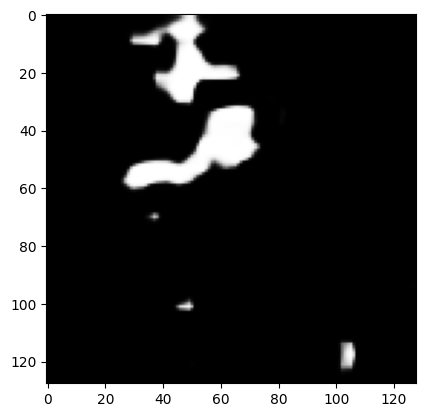

In [15]:
plt.imshow(, cmap='grey')

In [326]:
model_2.evaluate(X_test_org, y_test_org)

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.9351 - loss: 0.3280 - mean_io_u_4: 0.3765


[0.3279578685760498, 0.3764658272266388, 0.935143232345581]

In [328]:
label_pred = model_2.predict(X_test_org)
label_pred[label_pred >= 0.5] = 1
label_pred[label_pred < 0.5] = 0
len(label_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


31

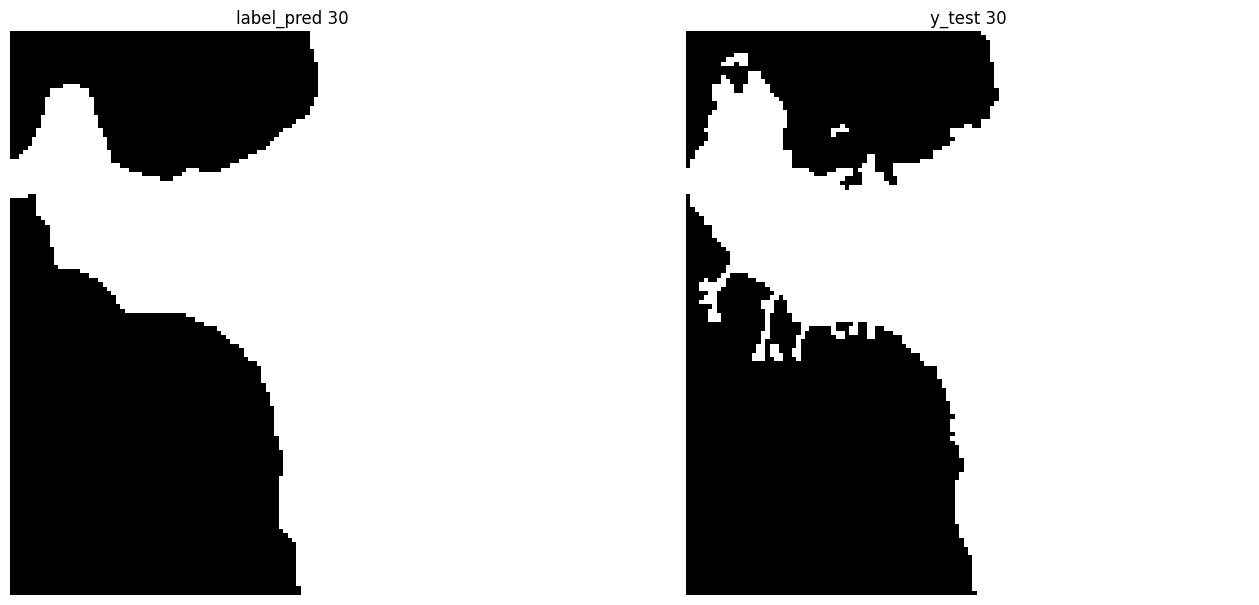

In [338]:
rand_num = random.randint(0, len(label_pred)-1)
plt.figure(figsize=(16, 14))
plt.subplot(121)
plt.axis('off')
plt.title(f'label_pred {rand_num}')
plt.imshow(label_pred[rand_num], cmap='gray')
plt.subplot(122)
plt.axis('off')
plt.title(f'y_test {rand_num}')
plt.imshow(y_test_org[rand_num], cmap='gray')